In [1]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import numpy as np
import qiskit
import copy
import matplotlib.pyplot as plt

In [2]:
iris=datasets.load_iris()
x=iris.data[0:100]
y=iris.target[0:100]
x_train, x_test, y_train, y_test= model_selection.train_test_split(x, y, test_size=0.2, random_state=42)

In [3]:
y_train

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [4]:
x_train[0:5]
x_train.shape

(80, 4)

In [5]:
x_train.dtype

dtype('float64')

In [6]:
N=4

In [7]:
def feature_map(X):
    q=QuantumRegister(N)
    c=ClassicalRegister(1)
    qc=QuantumCircuit(q,c)

    for i, x in enumerate(X):
        qc.rx(x, i)
    return qc, c

In [8]:
def variational_circuit(qc, theta):
    
    for i in range(N-1):
        qc.cx(i,i+1)
    qc.cx(N-1, 0)
    for i in range(N):
        qc.ry(theta[i], i)
    return qc

In [9]:
def quantum_nn(x, theta, simulator=True):
    qc,c=feature_map(x)
    qc.barrier()
    qc=variational_circuit(qc, theta)
    qc.barrier()
    qc.measure(0,c)


    shots=1E4
    backend=Aer.get_backend('qasm_simulator')
    job=qiskit.execute(qc, backend, shots=shots)
    result=job.result()
    counts=result.get_counts()
    
    return counts['1']/shots

In [10]:
def loss_function(prediction, target):
    return (prediction-target)**2

In [11]:
def gradient(x, y, theta):
    
    delta=0.01
    grad=[]
    for i in range(len(theta)):
        dtheta=copy.copy(theta)
        dtheta[i]+=delta
        
        pred1=quantum_nn(x, dtheta)
        pred2=quantum_nn(x, theta)
        
        grad.append((loss_function(pred1,y)-loss_function(pred2,y))/delta)
        
        return np.array(grad)

In [12]:
def accuracy(x, y, theta):
    counter=0
    for x_i, y_i in zip(x,y):
        prediction= quantum_nn(x_i, theta)
        
        if prediction <0.5 and y_i==0:
            counter +=1
        elif prediction >=0.5 and y_i==1:
            counter +=1
    return counter/len(y)

In [13]:
eta=0.01
loss_list=[]
theta=np.ones(N)
print('Epoch \t Loss \t Training accuracy')

for i in range(20):
    loss_temp=[]
    for x_i, y_i in zip(x_train, y_train):

        prediction= quantum_nn(x_i, theta)
        loss_temp.append(loss_function(prediction, y_i))
        theta= theta- eta * gradient(x_i, y_i, theta)
    
    loss_list.append(np.mean(loss_temp))
    acc = accuracy(x_train, y_train, theta)
    
    print(f'{i} \t {loss_list[-1]:3f} \t {acc:3f}')

Epoch 	 Loss 	 Training accuracy
0 	 0.281940 	 0.200000
1 	 0.280463 	 0.212500
2 	 0.276035 	 0.200000
3 	 0.278977 	 0.212500
4 	 0.274834 	 0.175000
5 	 0.279942 	 0.187500
6 	 0.285846 	 0.162500
7 	 0.283381 	 0.200000
8 	 0.280511 	 0.200000
9 	 0.279539 	 0.162500
10 	 0.282218 	 0.200000
11 	 0.278755 	 0.187500
12 	 0.276930 	 0.225000
13 	 0.275372 	 0.187500
14 	 0.272807 	 0.237500
15 	 0.273426 	 0.175000
16 	 0.271082 	 0.200000
17 	 0.264990 	 0.275000
18 	 0.258913 	 0.187500
19 	 0.261101 	 0.225000


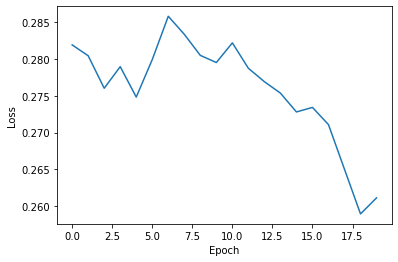

In [14]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [15]:
accuracy(x_test, y_test, theta)

0.25

In [16]:
clf=svm.SVC()
clf.fit(x_train, y_train)

SVC()

In [17]:
y_pred= clf.predict(x_test)
print(y_pred)
print(y_test)

[1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0]
[1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0]


In [18]:
from sklearn import metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")

accuracy 1.0 

